In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import dump
import csv
from surprise import accuracy
from pprint import pprint

In [2]:
csv_path = os.path.join("../data/csv/reviews_cleaned_reduced_500.csv")
TextFileReader = pd.read_csv(csv_path, chunksize=1000)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)


In [4]:
# The algorithm below reduces the memory size of a dataframe
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [5]:
props = df
props, NAlist = reduce_mem_usage(props)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 23.854185104370117  MB
******************************
Column:  beer_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  score
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  14.312536239624023  MB
This is  60.000105545428795 % of the initial size
_________________

_________________

[]


In [6]:
# load beers
csv_path = os.path.join("../data/csv/beers.csv")
beers_df = pd.read_csv(csv_path)
beers_df.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [7]:
beers_df = beers_df.rename(columns={'id': 'beer_id'})
beers_df.head()

,beer_id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [8]:
# Lets combine the dataframe
merge_df = pd.merge(df,
                 beers_df[['beer_id', 'name', 'style', 'brewery_id']],
                 on='beer_id')
merge_df.head()

,beer_id,username,score,name,style,brewery_id
0,942,ryan1788a5,3.54,Full Sail IPA,American IPA,5316
1,942,jonaspb,3.00,Full Sail IPA,American IPA,5316
2,942,bucklemyshoe,2.64,Full Sail IPA,American IPA,5316
3,942,velosuds,3.88,Full Sail IPA,American IPA,5316
4,942,tommy5,3.18,Full Sail IPA,American IPA,5316


In [9]:
merge_df.shape

(1250643, 6)

In [10]:
# The algorithm below reduces the memory size of a dataframe
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [11]:
props = df
props, NAlist = reduce_mem_usage(props)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 14.312536239624023  MB
******************************
Column:  beer_id
dtype before:  uint32
dtype after:  uint32
******************************
******************************
Column:  score
dtype before:  float32
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  14.312536239624023  MB
This is  100.0 % of the initial size
_________________

_________________

[]


In [12]:
merge_df.to_csv("../data/csv/beer_reviews_clean_500.csv",index=False)

In [13]:
merge_df['beer_id'].value_counts()

11757     4798
2093      4499
1093      4303
29619     4272
10672     4027
          ... 
169611     503
18721      502
84772      502
118971     501
39258      501
Name: beer_id, Length: 1175, dtype: int64

In [22]:
mean_score = merge_df.groupby('beer_id', as_index=False)[['score']].mean()
riids = mean_score['beer_id']
riids = riids.to_list()
type(riids)

list

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1518A208>,
      dtype=object)

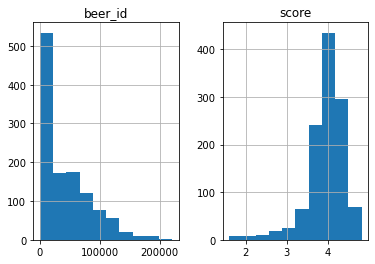

In [15]:
mean_score.hist()

In [69]:
# sample random trainset and testset method using Pearson similarity
# test set is made of 25% of the ratings. we are looking at similarities between items (user_based=false)
reader=Reader(rating_scale=(0,5))
data = Dataset.load_from_df(merge_df[['username', 'beer_id', 'score']], reader)

trainset, testset = train_test_split(data, test_size=.25)

sim_options = {'name': 'pearson',
               'user_based': False
               }

# We'll use KNN.
algo = KNNBasic(min_k = 10, sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.4958
MAE:  0.3600


0.359962365308972

In [100]:
# Lets serialize and save this prediction algorithm
# Dump algorithm and reload it
file_name_algo = os.path.join('../data/dump/algo_knn_500dump_file')
dump.dump(file_name_algo, algo=algo)
file_name_pred = os.path.join('../data/dump/pred_knn_500dump_file')
dump.dump(file_name_pred, predictions=predictions)

In [16]:
# sample random trainset and testset method Using Cosine similarity
# test set is made of 25% of the ratings. we are looking at similarities between items (user_based=false)
reader=Reader(rating_scale=(0,5))
data = Dataset.load_from_df(merge_df[['username', 'beer_id', 'score']], reader)

trainset, testset = train_test_split(data, test_size=.25)

sim_options = {'name': 'cosine',
               'user_based': False
               }

# We'll use KNN.
algo = KNNBasic(min_k = 5, sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5621
MAE:  0.3951


0.3950725235413905

In [17]:
# Lets serialize and save this prediction algorithm
# Dump algorithm and reload it
file_name_algo = os.path.join('../data/dump/algo_knn_cosine_500dump_file')
dump.dump(file_name_algo, algo=algo)
file_name_pred = os.path.join('../data/dump/pred_knn_cosine_500dump_file')
dump.dump(file_name_pred, predictions=predictions)

In [20]:
# Code below identifes the top 10 best and worst predictions based upon code from this 
# notebook:https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
def get_inner_ids(riid):
    inner_ids = []
    for riid in riids:
        inner_ids.append(trainset.to_inner_iid(riid))
    return inner_ids
        
    
df_predict = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predict['Iu'] = df_predict.uid.apply(get_Iu)
df_predict['Ui'] = df_predict.iid.apply(get_Ui)
df_predict['err'] = abs(df_predict.est - df_predict.rui)
best_predictions = df_predict.sort_values(by='err')[:10]
worst_predictions = df_predict.sort_values(by='err')[-10:]   

In [27]:
# Save the df_predict and df_ids for later use
riid =  232
inner_ids = get_inner_ids(riid)
df_predict.to_csv("../data/csv/df_predict_cosine_500.csv",index=False)
df_ids = pd.DataFrame(list(zip(riids,inner_ids)), columns=['beer_id', 'inner_ids'])
df_ids.head(10)

,beer_id,inner_ids
0,5,260
1,6,198
2,7,76
3,10,996
4,17,209
5,30,165
6,31,241
7,33,393
8,34,264
9,39,535


In [28]:
pd.DataFrame(list(zip(beers_id_recc,beer_name_recc,beer_style_recc,beer_score_mean)),
                                       columns=['beer_id', 'name', 'style', 'score_mean'])

NameError: name 'beers_id_recc' is not defined

In [17]:
# Best Predictions:
print(best_predictions)

                 uid    iid  rui  est  \
52525       bmcduff2    232  1.0  1.0   
283495     100200300    580  3.0  3.0   
167345      bmcduff2    355  1.0  1.0   
35169       bmcduff2    862  1.0  1.0   
11340       bmcduff2  45591  1.0  1.0   
306275  DrunkyBuddha  19314  5.0  5.0   
137321  DrunkyBuddha   7597  5.0  5.0   
165282  DrunkyBuddha  82250  5.0  5.0   
109345  DrunkyBuddha  34420  5.0  5.0   
89682       bmcduff2   1351  1.0  1.0   

                                          details  Iu    Ui  err  
52525   {'actual_k': 36, 'was_impossible': False}  39  1275  0.0  
283495  {'actual_k': 40, 'was_impossible': False}  60   918  0.0  
167345  {'actual_k': 32, 'was_impossible': False}  39  1913  0.0  
35169   {'actual_k': 37, 'was_impossible': False}  39   738  0.0  
11340   {'actual_k': 35, 'was_impossible': False}  39   422  0.0  
306275  {'actual_k': 40, 'was_impossible': False}  91   643  0.0  
137321  {'actual_k': 40, 'was_impossible': False}  91  1231  0.0  
165282  {'ac

In [18]:
# Best Predictions:
print(worst_predictions)

                     uid    iid  rui       est  \
181530  stairwell2811bre  74986  1.0  4.330503   
6603           wesside89  72720  1.0  4.336915   
134026            rbmjr1    754  1.0  4.350796   
287476       tigerbeer90   1161  1.0  4.359389   
52566             DevinK  16814  1.0  4.380992   
12621              bdtva  26049  1.0  4.389625   
37231           flipdog0   1545  1.0  4.450741   
205299              ucis   1320  1.0  4.623143   
61164            Schimms   1320  1.0  4.719515   
65687             sdpaul   7520  1.0  4.766071   

                                          details  Iu    Ui       err  
181530  {'actual_k': 28, 'was_impossible': False}  28  2642  3.330503  
6603    {'actual_k': 37, 'was_impossible': False}  57   452  3.336915  
134026  {'actual_k': 40, 'was_impossible': False}  53  1712  3.350796  
287476  {'actual_k': 40, 'was_impossible': False}  45  1719  3.359389  
52566   {'actual_k': 40, 'was_impossible': False}  61  2470  3.380992  
12621   {'actual_

In [24]:
def get_beer_name (beer_raw_id):
    beer_name = beers_df.loc[beers_df.beer_id==beer_raw_id,'name'].values[0]
    return beer_name

def get_beer_style (beer_raw_id):
    beer_style = beers_df.loc[beers_df.beer_id==beer_raw_id,'style'].values[0]
    return beer_style

def get_beer_score_mean (beer_raw_id):
    score_mean = mean_score.loc[mean_score.beer_id==beer_raw_id,'score'].values[0]
    return score_mean

# def get_beer_neighbors (beer_raw_id):
#     beer_inner_id = algo.trainset.to_inner_iid(beer_raw_id)
#     beer_neighbors = algo.get_neighbors(beer_inner_id, k=5)
#     beer_neighbors = (algo.trainset.to_raw_iid(inner_id)
#                   for inner_id in beer_neighbors)
#     return(beer_neighbors)

def get_beer_recc_df (beer_raw_id):
    beer_inner_id = algo.trainset.to_inner_iid(beer_raw_id)
    beer_neighbors = algo.get_neighbors(beer_inner_id, k=10)
    beer_neighbors = (algo.trainset.to_raw_iid(inner_id)
                      for inner_id in beer_neighbors)
    beers_id_recc = []
    beer_name_recc =[]
    beer_style_recc = []
    beer_score_mean = []
    for beer in beer_neighbors:
        beers_id_recc.append(beer)
        beer_name_recc.append(get_beer_name(beer))
        beer_style_recc.append(get_beer_style(beer))
        beer_score_mean.append(get_beer_score_mean(beer))
    beer_reccomendations_df = pd.DataFrame(list(zip(beers_id_recc,beer_name_recc,beer_style_recc,beer_score_mean)),
                                       columns=['beer_id', 'name', 'style', 'score_mean'])
    return beer_reccomendations_df

In [25]:
inner_ids = []


In [63]:
# Lets test some beers.  Enter a beer and use the predictions model to return 5 nearest neighbors
# K=5, pearson

beer_raw_id =  232
print(f'The 5 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head()

The 5 nearest neighbors of Corona Extra, American Adjunct Lager, score = 2.2471089363098145 are:


,beer_id,name,style,score_mean
0,233,Corona Light,American Light Lager,1.884826
1,3824,Monty Python's Holy Grail Ale,English Pale Ale,3.343782
2,1321,Modelo Especial,American Adjunct Lager,2.763934
3,63224,Blue Moon Winter Abbey Ale,Belgian Dubbel,3.003898
4,3734,Michelob Ultra,American Light Lager,1.795151


In [64]:
# Lets test some beers.  Enter a beer and use the predictions model to return 5 nearest neighbors

beer_raw_id =  19314
print(f'The 5 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head()

The 5 nearest neighbors of La Roja, Flanders Red Ale, score = 4.012190818786621 are:


,beer_id,name,style,score_mean
0,189272,Ten FIDY - Bourbon Barrel Aged,Russian Imperial Stout,4.465606
1,674,Westmalle Trappist Dubbel,Belgian Dubbel,4.165857
2,2270,Carlsberg Beer,European Pale Lager,2.986184
3,211516,Doppelganger,New England IPA,4.568240
4,139521,Barrel Aged Bomb!,American Imperial Stout,4.478484


In [65]:
# Lets test some beers.  Enter a beer and use the predictions model to return 5 nearest neighbors

beer_raw_id =  26049
print(f'The 5 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head()

The 5 nearest neighbors of Wild Blue, Fruit and Field Beer, score = 2.1567888259887695 are:


,beer_id,name,style,score_mean
0,172420,No Rules,American Imperial Porter,4.471152
1,6947,Cuvée Van De Keizer Blauw (Blue),Belgian Strong Dark Ale,4.270832
2,76899,Bud Light Platinum,American Light Lager,2.112869
3,127652,Second Fiddle,American Imperial IPA,4.431614
4,93643,Bois - Bourbon Barrel-Aged,English Old Ale,4.319534


In [68]:
# Lets test some beers.  Enter a beer and use the predictions model to return 5 nearest neighbors

beer_raw_id =  6108
print(f'The 5 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head()

The 5 nearest neighbors of 60 Minute IPA, American IPA, score = 4.019886493682861 are:


,beer_id,name,style,score_mean
0,154542,Mosaic Dry Hopped Fort Point,American Pale Ale (APA),4.498178
1,111538,Off Color / Amager - Dino S'mores,Russian Imperial Stout,4.118821
2,16400,Wee Heavy,Scotch Ale / Wee Heavy,4.159662
3,150933,High West-ified Imperial Coffee Stout,American Imperial Stout,4.368985
4,114804,Crusher,New England IPA,4.473433


In [74]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  232
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Corona Extra, American Adjunct Lager, score = 2.2471089363098145 are:


,beer_id,name,style,score_mean
0,233,Corona Light,American Light Lager,1.884826
1,26049,Wild Blue,Fruit and Field Beer,2.156789
2,90141,Freak Of Nature,American Imperial IPA,4.278668
3,75086,11.11.11 Vertical Epic Ale,Chile Beer,3.780256
4,2803,Sol,American Adjunct Lager,2.391426
5,810,Mickey's,American Malt Liquor,2.413893
6,1426,Grolsch Premium Lager,European Pale Lager,3.052222
7,1321,Modelo Especial,American Adjunct Lager,2.763934
8,1371,Labatt Blue,American Adjunct Lager,2.576830
9,34804,Landshark Lager,American Adjunct Lager,2.507511


In [77]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  412
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Old Rasputin, Russian Imperial Stout, score = 4.270477771759033 are:


,beer_id,name,style,score_mean
0,1655,Red Rocket Ale,American Amber / Red Ale,4.052642
1,127728,Yvan The Great: Belgian-Style Blonde (Beer Cam...,Belgian Blonde Ale,3.718615
2,87109,Terrapin Liquid Bliss,American Porter,3.788704
3,127730,Tater Ridge: Scottish Ale (Beer Camp Across Am...,Scottish Ale,3.602797
4,2961,Domaine DuPage French Style Country Ale,French Bière de Garde,3.770585
5,283,Sierra Nevada Stout,American Stout,4.047086
6,402,Skull Splitter,Scotch Ale / Wee Heavy,4.065929
7,1891,Third Coast Old Ale,American Barleywine,4.103450
8,50697,Double Jack,American Imperial IPA,4.297513
9,1115,Lion Stout,Foreign / Export Stout,3.881602


In [78]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  332
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Miller Lite, American Light Lager, score = 2.06624174118042 are:


,beer_id,name,style,score_mean
0,12068,Exponential Hoppiness,American Imperial IPA,4.395072
1,580,Miller High Life,American Adjunct Lager,2.571435
2,1276,Coors Banquet,American Adjunct Lager,2.518194
3,1341,Keystone Light,American Light Lager,1.716901
4,2280,Miller Genuine Draft,American Adjunct Lager,2.183389
5,48933,UFO White,Belgian Witbier,3.526161
6,21466,Fort,Fruit and Field Beer,3.737482
7,2435,Beck's,German Pilsner,2.713063
8,63724,Oude Tart - Cherries,Flanders Red Ale,4.412661
9,653,Natural Ice,American Adjunct Lager,1.712514


In [80]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  2512
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Chimay Grande Réserve (Blue), Belgian Strong Dark Ale, score = 4.253742694854736 are:


,beer_id,name,style,score_mean
0,1346,Chimay Tripel (White),Belgian Tripel,4.109288
1,672,Chimay Première (Red),Belgian Dubbel,4.123422
2,127728,Yvan The Great: Belgian-Style Blonde (Beer Cam...,Belgian Blonde Ale,3.718615
3,1421,Delirium Nocturnum,Belgian Strong Dark Ale,3.983673
4,127724,There And Back: English-Style Bitter (Beer Cam...,English Bitter,3.641695
5,87109,Terrapin Liquid Bliss,American Porter,3.788704
6,154542,Mosaic Dry Hopped Fort Point,American Pale Ale (APA),4.498178
7,410,Ruedrich's Red Seal Ale,American Amber / Red Ale,3.875684
8,674,Westmalle Trappist Dubbel,Belgian Dubbel,4.165857
9,119252,Dark Horse Smells Like A Safety Meeting,American Imperial IPA,3.928105


In [81]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  1352
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Shiner Bock, German Bock, score = 3.087606430053711 are:


,beer_id,name,style,score_mean
0,1312,Molson Canadian Lager,American Adjunct Lager,2.755008
1,10330,Aphrodisiaque,American Stout,4.182266
2,1053,Moosehead Lager,American Lager,2.918225
3,810,Mickey's,American Malt Liquor,2.413893
4,113859,Sierra Nevada Blindfold Black IPA,American Black Ale,3.822555
5,1260,Unfiltered Wheat,American Pale Wheat Ale,3.497116
6,126806,Mars (The Bringer Of War),American Imperial IPA,4.082902
7,74,Post Road Pumpkin Ale,Pumpkin Beer,3.460403
8,67722,Bourbon Barrel Aged Siberian Night Imperial Stout,Russian Imperial Stout,4.230687
9,1371,Labatt Blue,American Adjunct Lager,2.576830


In [84]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  607
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Fat Tire Belgian Style Ale, American Amber / Red Ale, score = 3.5244343280792236 are:


,beer_id,name,style,score_mean
0,32432,Total Domination IPA,American IPA,3.640893
1,1053,Moosehead Lager,American Lager,2.918225
2,5357,Boon Oude Geuze Mariage Parfait,Belgian Gueuze,4.102476
3,1426,Grolsch Premium Lager,European Pale Lager,3.052222
4,32631,Brooklyn Summer Ale,English Pale Ale,3.538762
5,60420,Sierra Nevada Tumbler Autumn Brown Ale,American Brown Ale,3.828291
6,3128,Long Trail Ale,German Altbier,3.541389
7,38818,Chocolate Indulgence Stout,Belgian Dark Ale,3.807939
8,37966,Tricerahops Double IPA,American Imperial IPA,3.986860
9,33245,Lager of The Lakes,Bohemian Pilsener,3.639069


In [85]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id =  246
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Heineken Lager Beer, European Pale Lager, score = 2.6418709754943848 are:


,beer_id,name,style,score_mean
0,134064,Double Dry Hopped Congress Street,New England IPA,4.585468
1,1053,Moosehead Lager,American Lager,2.918225
2,976,Singha,European Pale Lager,2.993831
3,88209,Prairie Hop,Belgian Saison,4.176917
4,4394,Smuttynose Big A IPA,American Imperial IPA,3.943015
5,653,Natural Ice,American Adjunct Lager,1.712514
6,2755,Cerveza Pacifico Clara,American Adjunct Lager,2.647262
7,436,Amstel Light,American Light Lager,2.399250
8,22527,471 Small Batch IPA,American Imperial IPA,3.868085
9,2435,Beck's,German Pilsner,2.713063


In [87]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id = 2755 
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Cerveza Pacifico Clara, American Adjunct Lager, score = 2.6472620964050293 are:


,beer_id,name,style,score_mean
0,2803,Sol,American Adjunct Lager,2.391426
1,848,Tecate,American Adjunct Lager,2.500783
2,20732,Budweiser Select,American Light Lager,2.007452
3,118987,Road Warrior Imperial Rye India Pale Ale,American Imperial IPA,4.064209
4,73731,Samuel Adams Fat Jack Double Pumpkin Ale,Pumpkin Beer,3.632844
5,1249,Kirin Ichiban,American Lager,2.642880
6,34804,Landshark Lager,American Adjunct Lager,2.507511
7,1381,Yuengling Black & Tan,American Porter,3.156302
8,41505,Hardcore IPA,American Imperial IPA,3.911618
9,1907,Dos Equis Special Lager,American Adjunct Lager,2.682793


In [92]:
# Lets test some beers.  Enter a beer and use the predictions model to return 10 nearest neighbors
# K=10, pearson

beer_raw_id = 131
print(f'The 10 nearest neighbors of {get_beer_name(beer_raw_id)}, {get_beer_style(beer_raw_id)},\
 score = {get_beer_score_mean (beer_raw_id)} are:')
df = get_beer_recc_df (beer_raw_id)
df.head(10)

The 10 nearest neighbors of Celebrator, German Doppelbock, score = 4.299962997436523 are:


,beer_id,name,style,score_mean
0,696,California Kölsch,German Kölsch,3.533625
1,179482,IPA,American IPA,3.941913
2,119960,Dissenter,American Imperial Pilsner,4.091443
3,103990,Firestone 17 - Anniversary Ale,American Strong Ale,4.448454
4,83473,Pivo Pils,German Pilsner,3.929115
5,66245,Elevated IPA,American IPA,4.316832
6,53134,Mischief,Belgian Strong Pale Ale,3.979242
7,46983,Saison De Lente,Belgian Saison,4.006236
8,132,Ayinger Bräu Weisse,German Hefeweizen,4.139741
9,66195,Café Racer 15,American Imperial IPA,4.215812
